In [1]:
import pandas as pd
import yaml
import os
#import cv2                  #conda install conda-forge::opencv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import PIL.Image as Image
from tqdm.notebook import tqdm
%run parallel_functions.py
from parallel_functions import read_image_and_bbox, read_and_process_file
from joblib import Parallel, delayed

with open('data.yaml', 'r') as f:
    train_data = yaml.safe_load(f)
    number_classes=train_data['nc']
    classes=train_data['names']
    
train_path="./train"
val_path="./valid"

num_jobs=16

print(train_path)

def get_files(path, endswith):
    files = []
    for root, dirs, file in os.walk(path):
        for f in file:
            if f.endswith(endswith):
                files.append(f)
    return files

train_images=get_files(train_path+"/images", ".jpg")
valid_images=get_files(val_path+"/images", ".jpg")
train_labels=get_files(train_path+"/labels", ".txt")
valid_labels=get_files(val_path+"/labels", ".txt")

./train


In [2]:
def read_and_process_file(file_path):
    df = pd.read_csv(file_path, sep=" ", header=None)
    df.columns = ['class', 'x', 'y', 'w', 'h']
    df['image'] = os.path.basename(file_path).replace('.txt', '.jpg')
    df['class'] = df['class'].astype(int)
    return df

df_collection=Parallel(n_jobs=num_jobs)(delayed(read_and_process_file)(train_path+"/labels/"+file) for file in train_labels)
df=pd.concat(df_collection, ignore_index=True)

In [3]:
df_valid=pd.concat(Parallel(n_jobs=16)(delayed(read_and_process_file)(val_path+"/labels/"+file) for file in valid_labels), ignore_index=True)

In [4]:
# show rows with image 998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec077.jpg
df[df['image']=='998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec077.jpg']

,class,x,y,w,h,image
52923,34,0.360577,0.737981,0.097356,0.045673,998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...
52924,8,0.370192,0.640625,0.100962,0.048077,998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...
52925,11,0.399038,0.538462,0.100962,0.062500,998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...
52926,11,0.808894,0.402644,0.100962,0.063702,998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...


In [5]:
# get maximum number of bounding boxes in an image
max_boxes=df['image'].value_counts().max()
max_boxes

4

In [6]:
train_path=train_path+"/images"
val_path=val_path+"/images"

In [7]:
df['class'].unique().min()

0

In [8]:
# increase all classes by 1
df['class'] = df['class']+1
df['class'].unique().min()

1

In [9]:
class_dict={}
for i in range(number_classes):
    class_dict[i+1]=classes[i]
class_dict[0]='None'
number_classes=len(class_dict)

In [44]:
import imageio
train_chunks = [group for _, group in df.groupby('image')]
valid_chunks = [group for _, group in df_valid.groupby('image')]
def read_image_and_bbox(chunck, train_path):
    image = imageio.imread(train_path+"/"+chunck.iloc[0]['image'])
    image = Image.fromarray(image)
    return {"image": image, "chunck": chunck}

train_data=Parallel(n_jobs=num_jobs)(delayed(read_image_and_bbox)(chunck, train_path) for chunck in train_chunks)
valid_data=Parallel(n_jobs=num_jobs)(delayed(read_image_and_bbox)(chunck, val_path) for chunck in valid_chunks)

In [45]:
len(train_data), len(valid_data)

(14000, 4000)

In [28]:
train_data[0]["chunck"]

,class,x,y,w,h,image
0,52,0.460337,0.693510,0.064904,0.042067,000090528_jpg.rf.d50e89610e5c97c61632c290692f3...
1,38,0.644231,0.501202,0.063702,0.088942,000090528_jpg.rf.d50e89610e5c97c61632c290692f3...
2,38,0.614183,0.074519,0.064904,0.088942,000090528_jpg.rf.d50e89610e5c97c61632c290692f3...


<Axes: >

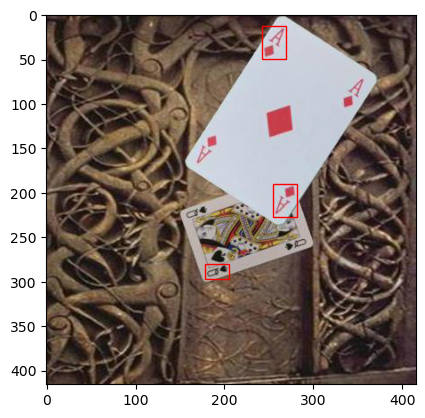

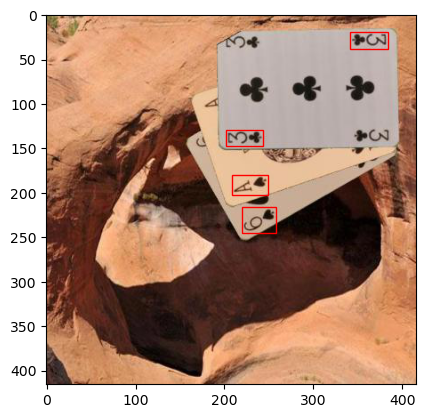

In [30]:
def show_boxes(image_data, show_class=False):
    image=image_data['image']
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    width, height = image.size
    bboxes=image_data["chunck"]
    
    for i in range(len(bboxes)):
        bbox=bboxes.iloc[i]
        x, y, w, h = bbox['x']*width, bbox['y']*height, bbox['w']*width, bbox['h']*height
        rect = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')	
        if show_class:
            ax.text(x-w/2, y-h/2, class_dict[bbox['class']], fontsize=12, color='white', backgroundcolor='red')
        ax.add_patch(rect)
    return ax

show_boxes(train_data[0])
show_boxes(train_data[1230])

In [34]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.df = df
        self.data = data
        self.size=len(data)
        self.transform = transform
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        image = self.data[idx]["image"]
        boxes=self.data[idx]["chunck"][['x', 'y', 'w', 'h']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        target = {}
        target['boxes'] = boxes
        target['objectness']=torch.ones(len(boxes), dtype=torch.int64)
        if len(target['boxes'])<4:
            target['boxes']=torch.cat((target['boxes'], torch.zeros(4-len(target['boxes']), 4)))
            target['objectness']=torch.cat((target['objectness'], torch.zeros(4-len(target['objectness']), dtype=torch.int64)))
        #transform
        if self.transform:
            image = self.transform(image)
        #print("image.shape in dataset", image.shape)
        #print("target in dataset", target)
        return image, target, idx
    
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor()])
dataset = Dataset(train_data, transform)
image, target, _ = dataset[0]

print(image.shape)

print(target)

torch.Size([3, 416, 416])
{'boxes': tensor([[0.4603, 0.6935, 0.0649, 0.0421],
        [0.6442, 0.5012, 0.0637, 0.0889],
        [0.6142, 0.0745, 0.0649, 0.0889],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'objectness': tensor([1, 1, 1, 0])}


In [35]:
import torchvision
from torchvision.models import ResNet50_Weights

class Model(torch.nn.Module):
    def __init__(self, hidden_size=None, dropout=0.4):
        super().__init__()
        self.backbone=torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        
        self.backbone_output_size=1000
        self.lin1=torch.nn.Linear(self.backbone_output_size, hidden_size)
        self.batch_norm_lin1=torch.nn.BatchNorm1d(hidden_size)
        self.lin2=torch.nn.Linear(hidden_size, hidden_size)
        number_classes=len(class_dict)
        number_boxes=4
        self.neurons_per_box=4+1      # 4 for bounding box, 2 for objectness, number_classes for class (objectness means if there is an object in the bounding box or not)
        output_neurons=number_boxes*self.neurons_per_box
        print("output_neurons:", output_neurons)
        self.lin3=torch.nn.Linear(hidden_size, output_neurons)
        self.relu=torch.nn.ReLU()                           
        self.dropout=torch.nn.Dropout(p=dropout)   
        # freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
 
    def forward(self, x):
        x=self.backbone(x)
        x=x.view(-1, self.backbone_output_size)
        x=self.lin1(x)
        x=self.batch_norm_lin1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.lin2(x)
        x=self.batch_norm_lin1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.lin3(x)
        # sigmoid for objectness, Neuron 5, 5+neurons_per_box, 5+2*neurons_per_box, 5+3*neurons_per_box
        for i in range(4):
            x[:, i*self.neurons_per_box+4]=torch.sigmoid(x[:, i*self.neurons_per_box+4])
        
        #sigmoid for x, y, w, h
        #for i in range(4):
        #    x[:, i*self.neurons_per_box]=torch.sigmoid(x[:, i*self.neurons_per_box])
        #    x[:, i*self.neurons_per_box+1]=torch.sigmoid(x[:, i*self.neurons_per_box+1])
        #    x[:, i*self.neurons_per_box+2]=torch.sigmoid(x[:, i*self.neurons_per_box+2])
        #    x[:, i*self.neurons_per_box+3]=torch.sigmoid(x[:, i*self.neurons_per_box+3])
        #x=torch.sigmoid(x)
        return x
    
model=Model(hidden_size=100)
loader=torch.utils.data.DataLoader(dataset, batch_size=13, shuffle=True)
for image, target, _ in loader:
    print(image.shape)
    output=model(image)
    assert output.shape[0]==13, "batch size is not correct, its "+str(output.shape[0])
    print(output.shape) 
    break


output_neurons: 20
torch.Size([13, 3, 416, 416])
torch.Size([13, 20])


In [36]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import torch.nn.functional as F


objectness_loss_fn=torch.nn.BCELoss()

def loss_fun(output, target):
    # output: batch_size , number_boxes x (4+2+number_classes)
    #        this means: for every box we have 4 coordinates, 1 objectness
    #                    the first 4 neurons are for the bounding box, the 5th neuron is for objectness, the last 53 neurons are for the class
    # mse for bounding box
    # cross entropy for object classification
    # cross entropy for objectness
    # sum up all losses
    
    number_boxes=4
    neurons_per_box=4+1
    output=output.view(-1, number_boxes, neurons_per_box)
    target_boxes=target['boxes']
    mse=torch.nn.MSELoss()
    
    #print("output.shape", output.shape)
    #print("single bbbox", output[0, 0, :4])
    #print("ground truth", target_boxes[0][0])
    #print("mse for this bbox", mse(output[0, 0, :4], target_boxes[0][0]))
    mse_loss=mse(output[:, :, :4], target_boxes)                            # ax 0: batch_size, ax 1: number_boxes, ax 2: 4 coordinates and 1 objectness
    objectness_loss=objectness_loss_fn(output[:, :, 4], target['objectness'].float())
    loss=mse_loss+objectness_loss
    return loss, {'mse_loss':mse_loss.item(), 'objectness_loss':objectness_loss.item()}
    

In [37]:
def get_validation_loss(model, loader, loss_fun):
    model.eval()
    with torch.no_grad():
        loss_sum=0
        detailed_losses={'mse_loss':0, 'objectness_loss':0}
        for image, target,_ in loader:
            image=image.to(device)
            target['boxes']=target['boxes'].to(device)
            target['objectness']=target['objectness'].to(device)
            output=model(image)
            loss, detailed_loss=loss_fun(output, target)
            loss_sum+=loss
            detailed_losses['mse_loss']+=detailed_loss['mse_loss']
            detailed_losses['objectness_loss']+=detailed_loss['objectness_loss']
        detailed_losses['mse_loss']=detailed_losses['mse_loss']/len(loader)
        detailed_losses['objectness_loss']=detailed_losses['objectness_loss']/len(loader)
        return loss_sum.item()/len(loader), detailed_losses

In [38]:
import neptune



In [39]:
import time

def train(epochs, lr, steps_valid=50, optimizer=None, model=None, loader=None, loader_valid=None, loss_fun=None, neptune_run=None):
    model.train()
    epoch_losses=[]
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(loader), epochs=epochs)
    learnrates=[]
    losses=[]
    mse_losses=[]
    objectness_losses=[]
    valid_losses={}
    postfix={}
    step=0
    last_valid_loss=100
    for epoch in range(epochs):
        bar=tqdm(loader, leave=False)
        bar.set_description(f"Epoch {epoch+1}/{epochs}")
        bar.set_postfix(postfix)
        current_timer=time.time()
        for image, target, _ in bar:
            times={}
            times['load image and target']=time.time()-current_timer
            model.train()
            optimizer.zero_grad()
            bar.update(1)
            current_timer=time.time()
            image=image.to(device)
            target['boxes']=target['boxes'].to(device)
            target['objectness']=target['objectness'].to(device)
            times['to_device']=time.time()-current_timer
            output=model(image)
            times['forward']=time.time()-current_timer-times['to_device']
            loss, detailed_loss=loss_fun(output, target)
            times['loss']=time.time()-current_timer-times['to_device']-times['forward']
            loss.backward()
            times['backward']=time.time()-current_timer-times['to_device']-times['forward']-times['loss']
            optimizer.step()
            times['step']=time.time()-current_timer-times['to_device']-times['forward']-times['loss']-times['backward']
            losses.append(loss.item())
            mse_losses.append(detailed_loss['mse_loss'])
            objectness_losses.append(detailed_loss['objectness_loss'])
            neptune_run["train/loss"].log(loss.item())
            neptune_run["train/mse_loss"].log(detailed_loss['mse_loss'])
            neptune_run["train/objectness_loss"].log(detailed_loss['objectness_loss'])
            step+=1
        
            if step%steps_valid==0:
                valid_loss, detailed_losses=get_validation_loss(model, loader_valid, loss_fun)
                valid_losses[step]={
                    'loss':valid_loss,
                    'mse_loss':detailed_losses['mse_loss'],
                    'objectness_loss':detailed_losses['objectness_loss']
                }
                neptune_run["valid/loss"].log(valid_loss)
                neptune_run["valid/mse_loss"].log(detailed_losses['mse_loss'])
                neptune_run["valid/objectness_loss"].log(detailed_losses['objectness_loss'])
                last_valid_loss=valid_loss
            scheduler.step()
            postfix={
                'loss': losses[-1],
                'mse_loss': mse_losses[-1],
                'objectness_loss': objectness_losses[-1],
                'valid_loss': last_valid_loss,
                'lr':scheduler.get_last_lr()[0]
            }
            run["train/lr"].log(scheduler.get_last_lr()[0])
            bar.set_postfix(postfix)
            print("times", times)
            current_timer=time.time()
            
    return {"losses":losses, "mse_losses":mse_losses, "objectness_losses":objectness_losses, 'valid_losses':valid_losses}

In [40]:
def plot_metrics(metrics):
    fig, ax=plt.subplots(2, 3, figsize=(20, 5))
    #increase space between rows
    plt.subplots_adjust(hspace = 0.5)
    ax[0,0].plot(metrics['losses'])
    ax[0,0].set_title("Loss")
    ax[0,1].plot(metrics['mse_losses'])
    ax[0,1].set_title("MSE Loss")
    ax[0,2].plot(metrics['objectness_losses'])
    ax[0,2].set_title("Objectness Loss")
    
    steps=list(metrics['valid_losses'].keys())
    valid_losses=[]
    for key in metrics['valid_losses']:
        valid_losses.append(metrics['valid_losses'][key]['loss'])
    ax[1,0].plot(valid_losses, steps)
    ax[1,0].set_title("Validation Loss")  
    
    valid_mse_losses=[]
    for key in metrics['valid_losses']:
        valid_mse_losses.append(metrics['valid_losses'][key]['mse_loss'])
    ax[1,1].plot(valid_mse_losses)
    ax[1,1].set_title("Validation MSE Loss")
    
    valid_objectness_losses=[]
    for key in metrics['valid_losses']:
        valid_objectness_losses.append(metrics['valid_losses'][key]['objectness_loss'])
    ax[1,2].plot(valid_objectness_losses)
    ax[1,2].set_title("Validation Objectness Loss")
    plt.show()


In [46]:
torch.cuda.empty_cache()
model=Model(hidden_size=1000)
model.to(device)

lr=0.001
wd=0.0001

optimizer=torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
loader=torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)
loader_valid=torch.utils.data.DataLoader(Dataset(valid_data, transform), batch_size=256, shuffle=True)

run = neptune.init_run(
    project="bernd.heidemann/cards-detection",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzNjBlYzVkNi0zZTUwLTQ1ODYtODhlNC02NDUxNDg0MDdjNzUifQ==",
)  # your credentials
params = {
    "learning_rate": lr, 
    "optimizer": "AdamW", 
    "weight_decay": wd
}
run["parameters"] = params
loss_fn=loss_fun

metrics=train(5, lr, steps_valid=20, optimizer=optimizer, model=model, loader=loader, loader_valid=loader_valid, loss_fun=loss_fn, neptune_run=run)
plot_metrics(metrics)


output_neurons: 20


c:\Users\Bernd\anaconda3\envs\mytorch\lib\site-packages\neptune\common\warnings.py:71: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  warnings.warn(


https://app.neptune.ai/bernd.heidemann/cards-detection/e/CAR-15


  0%|          | 0/55 [00:00<?, ?it/s]

times {'load image and target': 0.37297797203063965, 'to_device': 0.08499550819396973, 'forward': 3.451808214187622, 'loss': 0.01000070571899414, 'backward': 0.020998239517211914, 'step': 0.019000530242919922}
times {'load image and target': 0.3489813804626465, 'to_device': 0.03799700736999512, 'forward': 0.005998134613037109, 'loss': 0.5319716930389404, 'backward': 0.0009999275207519531, 'step': 0.0009999275207519531}
times {'load image and target': 0.3649787902832031, 'to_device': 0.03699803352355957, 'forward': 0.004999637603759766, 'loss': 0.533970832824707, 'backward': 0.0009999275207519531, 'step': 0.0010004043579101562}
times {'load image and target': 0.35198092460632324, 'to_device': 0.03599739074707031, 'forward': 0.005000591278076172, 'loss': 0.5349705219268799, 'backward': 0.0, 'step': 0.0009996891021728516}
times {'load image and target': 0.3589813709259033, 'to_device': 0.04099750518798828, 'forward': 0.004998445510864258, 'loss': 0.5319693088531494, 'backward': 0.00099968

KeyboardInterrupt: 

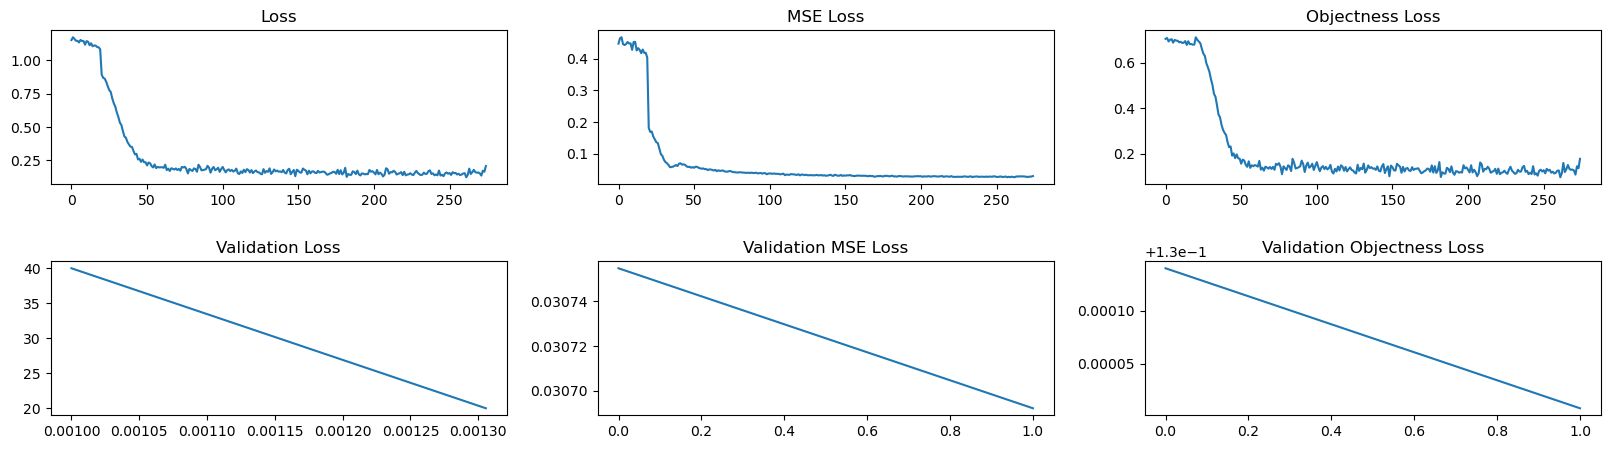

[20, 40]
[0.0013056264724582434, 0.0009999608155339956]


In [ ]:
sample={}

loader_valid=torch.utils.data.DataLoader(Dataset(df_valid, val_path, classes, transform), batch_size=32, shuffle=True)
cols=['path', 'x', 'y', 'w', 'h', 'objectness']
output_df=pd.DataFrame([], columns=cols)
for xb, yb, path in loader_valid:
    xb=xb.to(device)
    yb['boxes']=yb['boxes'].to(device)
    yb['objectness']=yb['objectness'].to(device)
    
    output=model(xb)
    
    for i in range(output.shape[0]):
        for j in range(4):
            single_path=path[i]
            x=output[i, j*5].cpu().detach().numpy()
            y=output[i, j*5+1].cpu().detach().numpy()
            w=output[i, j*5+2].cpu().detach().numpy()
            h=output[i, j*5+3].cpu().detach().numpy()
            objectness=output[i, j*5+4].cpu().detach().numpy()
            output_df.loc[len(output_df)]=[single_path, x, y, w, h, objectness]

    
    break
output_df

,path,x,y,w,h,objectness
0,815875606_jpg.rf.5ccec7772ed397b621b82dae03110...,0.41743076,0.29572886,0.15500873,0.20734476,0.9925236
1,815875606_jpg.rf.5ccec7772ed397b621b82dae03110...,0.40769252,0.5669599,0.24778727,0.18762736,0.992572
2,815875606_jpg.rf.5ccec7772ed397b621b82dae03110...,0.4768553,0.40583885,0.17146026,0.106464714,0.9635358
3,815875606_jpg.rf.5ccec7772ed397b621b82dae03110...,0.47914675,0.37828267,0.21817298,-0.039249443,0.8105464
4,743001244_jpg.rf.fc1988d34361fa4a89652da9b0f63...,0.5517186,0.40035567,-0.0072281323,0.14713548,0.99935323
...,...,...,...,...,...,...
123,986844487_jpg.rf.9435c80f03f2a1923ea337cdeb31f...,0.5254201,0.3681524,-0.0077465046,0.056743864,0.9011005
124,678378467_jpg.rf.fcc4794e691c22d40493fc2494a24...,0.51148236,0.5320281,-0.043480083,-0.0014707264,0.99790454
125,678378467_jpg.rf.fcc4794e691c22d40493fc2494a24...,0.48891997,0.58842975,0.0643214,0.2553801,0.9985732
126,678378467_jpg.rf.fcc4794e691c22d40493fc2494a24...,0.4263793,0.40281922,0.27948657,0.07220182,0.9819755


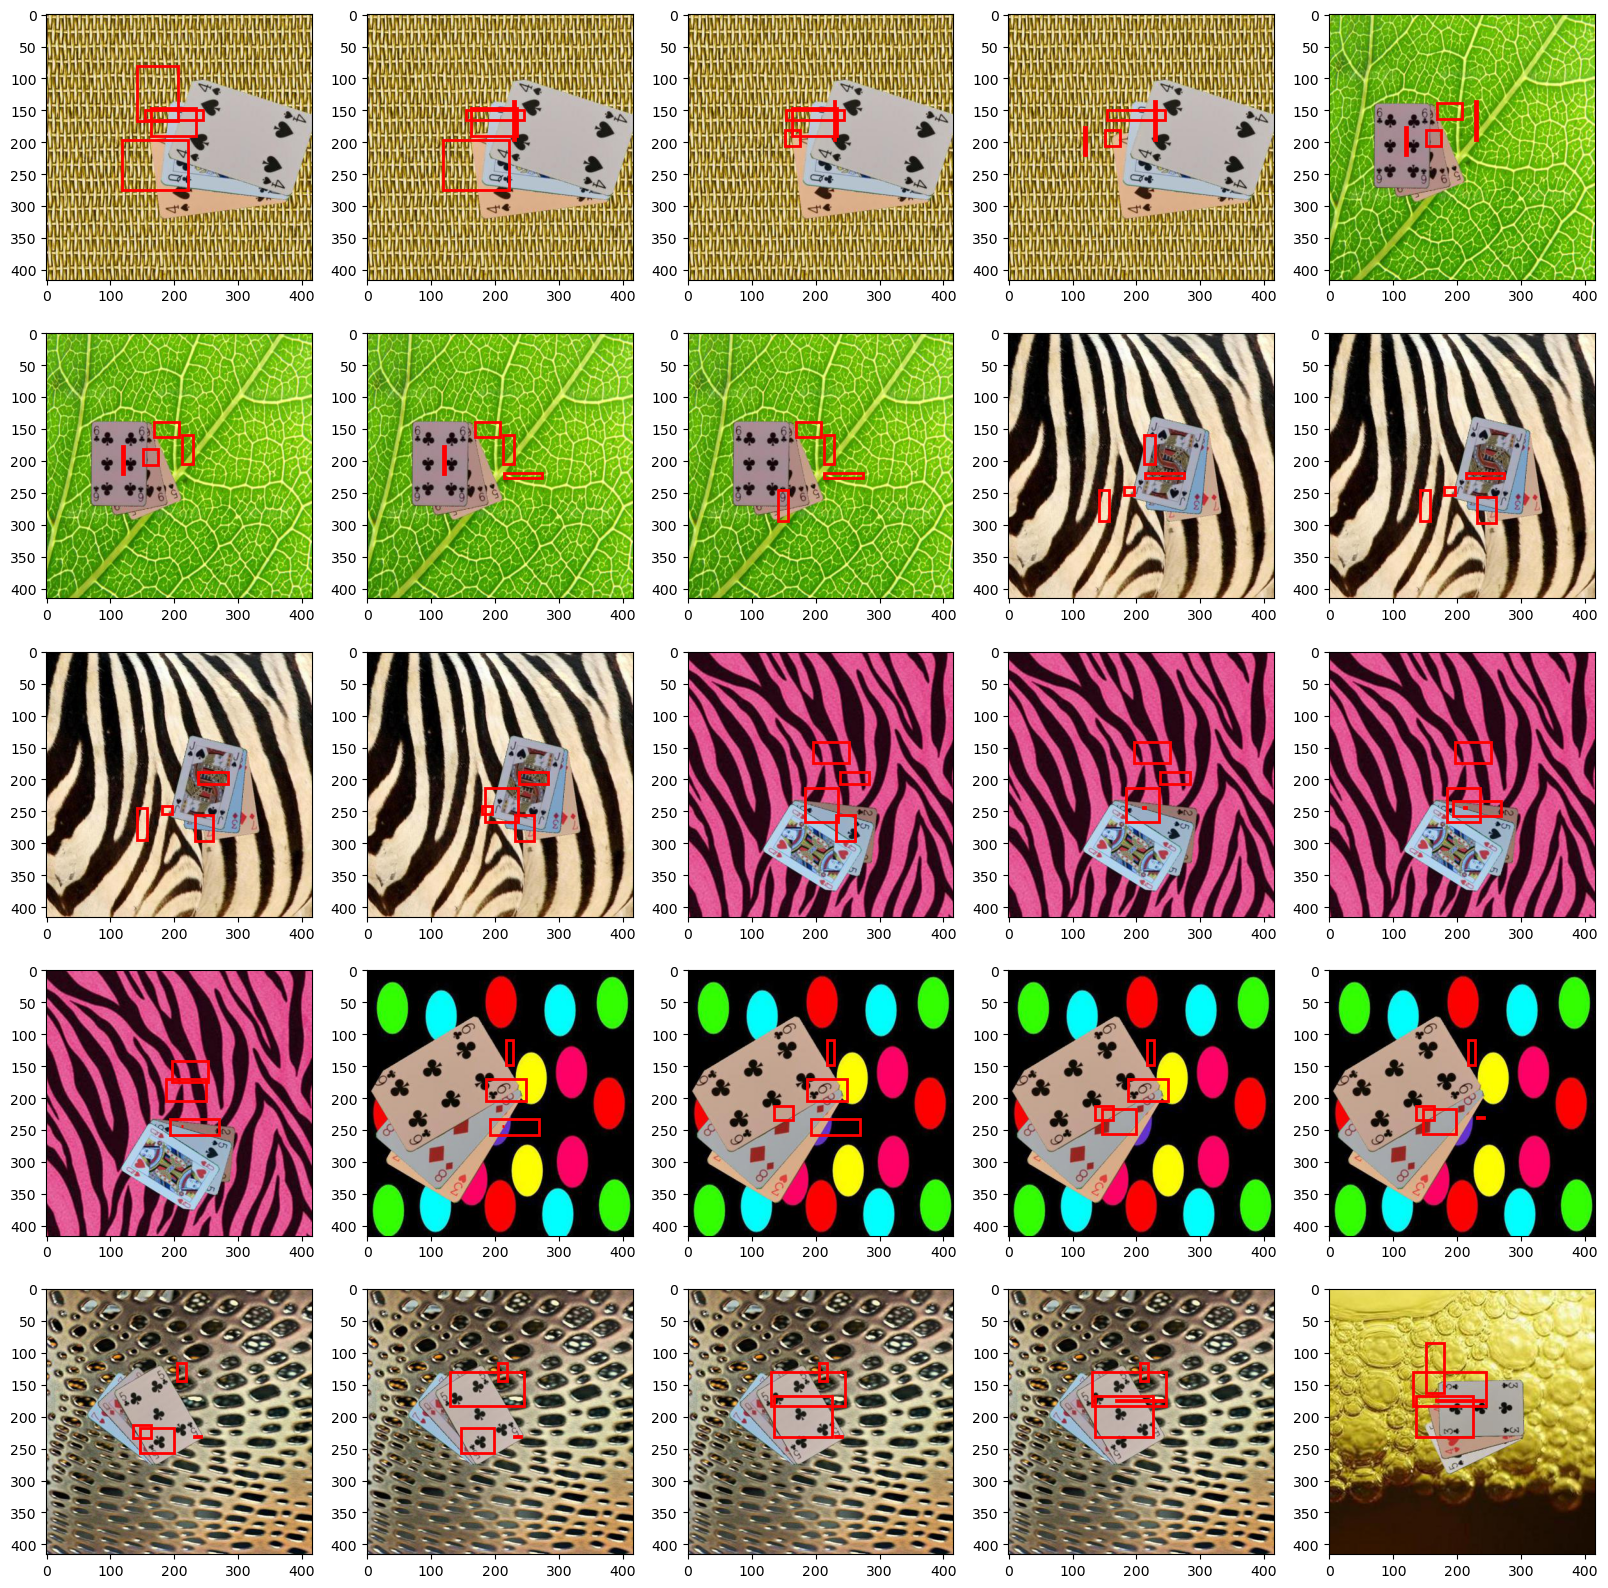

In [ ]:
number_images=25
fig, ax=plt.subplots(5, 5, figsize=(20, 20))
for i in range(number_images):
    imgage_path=output_df['path'][i]
    for j in range(4):
        x=output_df['x'][i+j]
        y=output_df['y'][i+j]
        w=output_df['w'][i+j]
        h=output_df['h'][i+j]
        objectness=output_df['objectness'][i+j]
        image=Image.open(val_path+"/"+imgage_path)
        ax[i//5, i%5].imshow(image)
        x=x*image.size[0]
        y=y*image.size[1]
        w=w*image.size[0]
        h=h*image.size[1]
        rect = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax[i//5, i%5].add_patch(rect)
        #ax[i//5, i%5].text(x-w/2, y-h/2, objectness, fontsize=12, color='white', backgroundcolor='red')
    

In [ ]:
# calulate mse between predicted and real bounding boxes


df_valid=df_valid[df_valid['image'].isin(output_df['path'])]

def calculate_mse(output_df, df_valid):
    mse=0
    
    same=0
    last_path=""
    for i in range(len(output_df)):
        if last_path!=output_df['path'][i]:
            same=0
            last_path=output_df['path'][i]
        else:
            same+=1
        image_path=output_df['path'][i]
        real_boxes=df_valid[df_valid['image']==image_path][['x', 'y', 'w', 'h']].values
        # fill real_boxes with zeros if there are less than 4 boxes
        if len(real_boxes)<4:
            real_boxes=np.concatenate((real_boxes, np.zeros((4-len(real_boxes), 4))))
       
        x=output_df['x'][i]
        y=output_df['y'][i]
        w=output_df['w'][i]
        h=output_df['h'][i]
        x=x*image.size[0]
        y=y*image.size[1]
        w=w*image.size[0]
        h=h*image.size[1]
        mse+=np.mean((real_boxes[same]-np.array([x, y, w, h]))**2)
        
    return mse/(len(output_df)*4)

calculate_mse(output_df, df_valid)

7364.070701567172